In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarQuadrotor
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `~/Documents/ocrl_hw/Quadrotor_MPC_with_Kalman_Filter/Project.toml`
Precompiling project...
  ✓ NBInclude
  ✓ WebIO
  ✓ JSExpr
  ✓ Blink
  ✓ MeshCat
  ✓ Ipopt
  6 dependencies successfully precompiled in 26 seconds (205 already precompiled)
┌ Info: Precompiling OSQP [ab2f91bb-94b4-55e3-9ba0-7f65df51de79]
└ @ Base loading.jl:1342
┌ Info: Precompiling MeshCat [283c5d60-a78f-5afe-a0af-af636b173e11]
└ @ Base loading.jl:1342
┌ Info: Precompiling Altro [5dcf52e5-e2fb-48e0-b826-96f46d2e3e73]
└ @ Base loading.jl:1342


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

The LQR formulation we used is a simple linearlization of the system about hover (i.e. all thrust vectors point straight down and sum to counter gravity).

This linearization gives us the following approximation of the system's dynamics:

$$x_{t+1} = A x_{t} + B u_{t}$$

Where A is the state Jacobian and B is the input Jacobian:
$$A = \frac{\partial x_{t+1}}{\partial x_{t}}, \quad B = \frac{\partial x_{t+1}}{\partial u_{t}}$$

This works so long as the quadrotor stays close to the point its dynamics were linearized about.

In [2]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")
nx = 13
nu = 4
dt = 0.025
T = 5.0
N = Int(T / dt)

model = Quadrotor()

x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
# Q[1:3,1:3] .= 100.0*I(3)
# Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);

# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LQR converged in 97 iterations


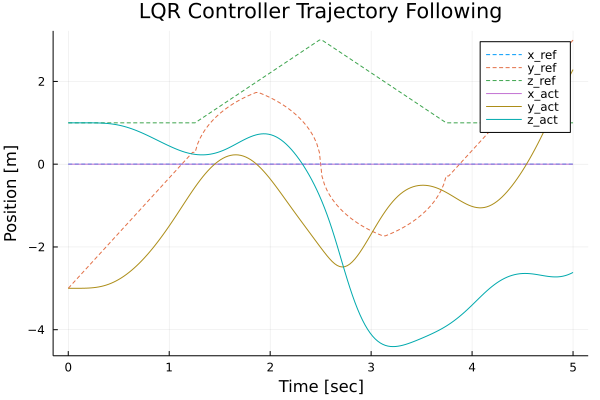

In [3]:
include("quadrotor.jl")
include("dynamics.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

# X_line = line_reference(N, dt)
X_line = flip_reference(N, dt)
# X_line = altro_reference_circle(N, dt, model)

X_LQR[1][1:4] .= X_line[1][1:4]
# println(X_LQR[1])
# X_LQR[1][4] = 1.0

vals_ref = zeros(N,3)
vals_ref[1,:] .= X_line[1][1:3]
vals_act = zeros(N,3)
vals_act[1,:] .= X_LQR[1][1:3]

for k = 1:N-1
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
plot!(tref, vals_act, label=["x_act" "y_act" "z_act"])

In [4]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/cory/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [ ]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
# flip_ref = flip_reference(N, dt)
flip_ref = altro_reference_circle(N, dt, model)
visualize!(vis, model, dt*(N-1), flip_ref)
plot(tref, vals_act, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
# visualize!(vis, model, dt*(N-1), X_LQR)


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 73
    Solve Time: 135.55116999999998 (ms)

  Covergence
    Terminal Cost: 22.913952340510704
    Terminal dJ: 3.6591416687770106e-6
    Terminal gradient: 0.00010103301229316599
    Terminal constraint violation: 1.16397025351489e-9
    Solve Status: SOLVE_SUCCEEDED


SVector{13, Float64}[[0.0, -10.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00046345062009982095, -9.999792561882415, 1.0071959406318574, 0.9890040891852503, -0.0603073948730156, 0.13474847045903635, 0.006055981275833189, 0.07361854626912384, 0.03328704669386287, 0.5696731082254151, -9.749079418434144, 21.610249708391233, 0.9698887351593877], [0.009629150163450954, -9.995270209999072, 1.0343332685693394, 0.9263056840777681, -0.1947879902931842, 0.3222513619149603, 0.012989496921645406, 0.738292045462049, 0.3867822277540174, 1.543826239947144, -12.019674011048773, 9.978519437843348, -1.5763545649355986], [0.04605654459394018, -9.973221364895055, 1.0875584383263284, 0.8510911111160135, -0.3105139083648685, 0.4232155184067912, 0.010616092781074955, 2.2214265418633787, 1.4402759712741267, 2.6139574724866055, -7.256803730869269, 9.259272454911924, -1.2921391418537673], [0.12238910510084706, -9.921418871836684, 1.160153405023747, 0.7813892412914416, -0.3810894733107731, 0.49

 0.47780894259684836, 10.555007311153215, 11.475904787811201, 1.0045216087261002, -1.7090608031851742, -3.18906999841752, -0.04310316694540517], [-7.4025867706136586, 3.1109250126930883, 1.1538261501673954, 0.7324347631919266, 0.2206083799091313, 0.431578866360013, 0.4781305943204949, 11.013371348465558, 11.537912174846008, 1.024135867055565, -1.676504161650916, -3.292924983475328, -0.0395101010470101], [-7.123276180642273, 3.3997131519493653, 1.179004050296792, 0.754384330425747, 0.22485683528636405, 0.3908519628098405, 0.47704963190636884, 11.3289922292733, 11.561573156982403, 0.9941289176851806, -1.6425073995025907, -3.3611294254392337, -0.03638044734269573], [-6.8373000931102315, 3.6888030765216753, 1.2029283428281785, 0.774854216323893, 0.22927407398167832, 0.34892918091267444, 0.47463743156599325, 11.54696442634694, 11.56293879434248, 0.9225095568943287, -1.6109298102349292, -3.4055976417935545, -0.03347424181209348], [-6.546694471170153, 3.977763011791554, 1.2246689145856595, 0.

 0.009373685556120441], [0.25254026031494337, 10.018323235784028, 1.346983260534805, 0.9117168318610903, 0.12909461504454708, -0.30806503572576194, 0.23916698099989717, 0.7861481132296655, 0.3034182314143634, 0.35032084682170783, -0.3690333119170654, 1.8044613425271727, 0.0084412569924023], [0.2713079712117543, 10.025232549722869, 1.3540943919943969, 0.9189292519880916, 0.1195437987706253, -0.28870034836808506, 0.24068305098838383, 0.715916816400091, 0.24990610187718468, 0.219239904181212, -0.3574650749581405, 1.772972721136919, 0.007542632619705968], [0.288302306425258, 10.030797348309331, 1.3580941269352138, 0.9255340767070617, 0.11017584095961754, -0.26954324550947134, 0.24205848029522897, 0.6443425878867273, 0.1959072852122981, 0.10140607175894685, -0.345013032219579, 1.7361245076555443, 0.006683314205183884], [0.30349182298724414, 10.035007712220118, 1.3593294717522961, 0.9315377774810781, 0.10102596298878351, -0.2506724160939245, 0.24329483326168966, 0.5715977252383326, 0.1416024

, 9.79949637578923, 1.2247010705378563, 0.9680541060218741, -0.016816072477248523, 0.024348793179305907, 0.24898497119128343, -0.21102140277878895, -0.26696058699271574, -0.006337487327129695, 0.020166845800604523, 0.0207025669348366, -7.116635148844111e-5], [0.21388068142560498, 9.792960084396357, 1.2245594422270023, 0.9680545065018027, -0.016605030398857558, 0.024578085615414035, 0.24897504935689782, -0.20137068238148562, -0.2559548656593958, -0.004993120524921288, 0.02169545465214613, 0.006430018568987669, -4.112958451746773e-5], [0.208967956562894, 9.786697584054163, 1.2244460755202564, 0.9680591594311925, -0.016335339090678604, 0.024648410644401444, 0.24896784627468585, -0.1916361720127006, -0.24506519131133542, -0.004075770335162494, 0.022918937633507067, -0.0062800451174799005, -1.1319862267365136e-5], [0.2042989888041045, 9.780705448864177, 1.2243512169556163, 0.9680675409609238, -0.016015268826236027, 0.024577188208685874, 0.2489630920635309, -0.18188034401024852, -0.234332510

# MPC Controller

**TODO: include constraints in this outline**

The MPC controller works by solving the following QP:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z\\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of states and controls at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B & -I \\ 
      & A & B & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A & B -I \\
\end{bmatrix}
\begin{bmatrix} u_0 \\ x_1 \\ u_1 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} = 
\begin{bmatrix} -A (x_k - x_{ref,k}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

TODO: explain re-linearization step using feed-forward dynamics

and the cost matrix $P$ is defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}
$$

In [ ]:
include("dynamics.jl")
include("quadrotor.jl")
include("quaternions.jl")

const n = state_dim(model)
const m = control_dim(model)

line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)

Uref = [copy(uhover) for i = 1:N]
umin = -5*uhover[1]
umax = 5*uhover[1]

A = []
B = []

for i=1:N
#     angle = angle_of_rotation_q(flip_ref[1][4:7])
#     thrust_des = uhover / cos(angle*2)
#     clamp!(thrust_des, umin, umax)
#     Uref[i] = thrust_des
    
    A_i, B_i = dynamics_jacobians(flip_ref[i],Uref[i],dt)
    J_attitude = attitude_jacobian(flip_ref[i])
    Ã_i = J_attitude'*A_i*J_attitude
    B̃_i = J_attitude'*B_i
    push!(A, Ã_i)
    push!(B, B̃_i)
    
end

In [ ]:
include("MPC.jl")
include("quaternions.jl")

# note: lower Q value means controller will be less inclined to adjust those values away from ref traj
# ... maybe. I actually think it may be the opposite

Q = 1.0*I(nx-1)
# Q[1:3,1:3] *= 0.1
Q[4:7,4:7] *= 10 # attitude
# Q[1:2] *= 0.05 
# Q[8:end] *= 10 # vel and angular vel
# Q[11,11] *= 0.01 # x angular vel
R = 1e-5*I(nu)
Qf = 1.0*I(nx-1)
Qf[1:3,1:3] *= 1e-3
Nmpc = 100

x0 = zeros(nx)
for i=1:7
    x0[i] = flip_ref[1][i]
end


mpc = build_MPC_QP(flip_ref, Uref, tref, A, B, Q, R, Qf);
X_mpc,U_mpc,t_mpc = simulate(model, x0, mpc, A, B, tf=T);

In [ ]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

In [ ]:
visualize!(vis, model, dt*(N-1), X_mpc)
# visualize!(vis, model, dt*(N-1), flip_ref)

In [ ]:
include("plotter.jl")
labs = ["x", "y", "z"]
indices = 1:3
plot_vals(flip_ref, X_mpc, indices, labs, "MPC position")

In [ ]:
labs = ["q0", "q1", "q2", "q3"]
indices = 4:7
plot_vals(flip_ref, X_mpc, indices, labs, "MPC attitude")

In [ ]:
labs = ["ωx", "ωy", "ωz"]
indices = 11:13
plot_vals(flip_ref, X_mpc, indices, labs, "MPC angular velocity")

In [ ]:
labs = ["vx", "vy", "vz"]
indices = 8:10
plot_vals(flip_ref, X_mpc, indices, labs, "MPC velocity")